# 1. 先进行模型预训练完整过程

2025-03-18 20:58:26.122375: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-18 20:58:26.134168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-18 20:58:26.150820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-18 20:58:26.150837: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 20:58:26.161982: I tensorflow/core/platform/cpu_feature_gua

YAMNet 模型从本地加载完成！
检测到类别： ['Angry', 'Defence', 'Fighting', 'Happy', 'HuntingMind', 'Mating', 'MotherCall', 'Paining', 'Resting', 'Warning']
处理类别 Angry，共 300 个文件


2025-03-18 20:58:34.212568: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


处理类别 Defence，共 291 个文件
处理类别 Fighting，共 286 个文件
处理类别 Happy，共 297 个文件


Note: Illegal Audio-MPEG-Header 0xbf082800 at offset 7536.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


处理类别 HuntingMind，共 289 个文件
处理类别 Mating，共 301 个文件
处理类别 MotherCall，共 296 个文件
处理类别 Paining，共 291 个文件
处理类别 Resting，共 296 个文件
处理类别 Warning，共 300 个文件
特征矩阵形状： (11788, 1024)
标签形状： (11788,)

📊 各分类器单独评估：
Random Forest: 0.8308
KNN: 0.8164
Extra Trees: 0.8473
LDA: 0.8109
SVM: 0.8312

开始训练 VotingClassifier (Hard Voting)...
VotingClassifier 集成准确率: 0.8507


/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

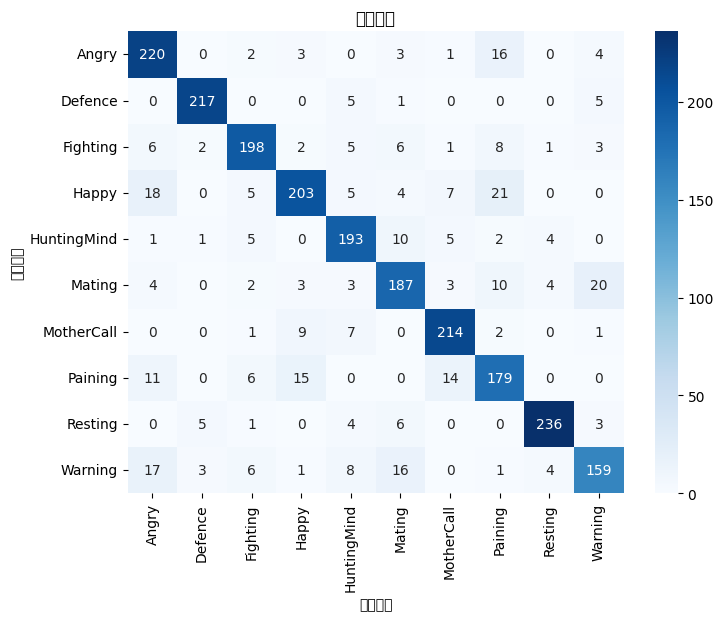

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 加载 YAMNet 预训练模型
local_model_path = '/root/.cache/kagglehub/models/google/yamnet/tensorFlow2/yamnet/1'
yamnet_model = hub.load(local_model_path)
print("YAMNet 模型从本地加载完成！")

def augment_audio(audio, sr):
    """
    对音频进行 3 种增强：
    1. 时间拉伸（0.9x ~ 1.1x）
    2. 音调平移（-4 ~ +4 半音）
    3. 加噪声（标准正态分布）
    返回 3 个增强后的音频
    """
    augments = []

    # 时间拉伸
    time_stretch = librosa.effects.time_stretch(audio, rate=np.random.uniform(0.9, 1.1))
    augments.append(time_stretch)

    # 音调平移
    pitch_shift = librosa.effects.pitch_shift(audio, sr=sr, n_steps=np.random.randint(-4, 5))
    augments.append(pitch_shift)

    # 添加高斯噪声
    noise = audio + np.random.normal(0, 0.005, audio.shape)
    augments.append(noise)

    return augments

def extract_yamnet_features_with_aug(file_path):
    """
    读取音频并提取 YAMNet 特征，同时生成 Augx3 数据增强版本
    """
    # 加载音频，采样率固定 16000
    audio, sr = librosa.load(file_path, sr=16000)

    # 提取原始音频的特征
    waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
    scores, embeddings, spectrogram = yamnet_model(waveform)
    original_feat = tf.reduce_mean(embeddings, axis=0).numpy().reshape((1024,))

    # 生成 3 个增强版本
    augmented_audios = augment_audio(audio, sr)
    augmented_features = []
    
    for aug_audio in augmented_audios:
        aug_waveform = tf.convert_to_tensor(aug_audio, dtype=tf.float32)
        scores, embeddings, spectrogram = yamnet_model(aug_waveform)
        aug_feat = tf.reduce_mean(embeddings, axis=0).numpy().reshape((1024,))
        augmented_features.append(aug_feat)

    return [original_feat] + augmented_features  # 返回原始 + 3 个增强版本


# 2. 生成特征数据集（假设你的数据集目录结构为：dataset_dir/ClassName/*.mp3 或 *.wav）
dataset_dir = "./CatSound"  # 修改为你的数据集路径
# 只保留有效类别（排除隐藏文件夹）
classes = sorted([d for d in os.listdir(dataset_dir) 
                  if os.path.isdir(os.path.join(dataset_dir, d)) and not d.startswith('.')])
print("检测到类别：", classes)

X = []  # 存储特征
y = []  # 存储标签

for label, cls in enumerate(classes):
    class_dir = os.path.join(dataset_dir, cls)
    files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.lower().endswith(('.mp3', '.wav'))]
    
    print(f"处理类别 {cls}，共 {len(files)} 个文件")
    for file in files:
        try:
            # 提取原始 + 3 个增强版本的特征
            features = extract_yamnet_features_with_aug(file)
            for feat in features:
                X.append(feat)
                y.append(label)
        except Exception as e:
            print(f"文件 {file} 处理失败：", e)

X = np.array(X)
y = np.array(y)
print("特征矩阵形状：", X.shape)
print("标签形状：", y.shape)

# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义分类器
clf_rf = RandomForestClassifier(n_estimators=200, random_state=42)
clf_knn = KNeighborsClassifier(n_neighbors=7)
clf_et = ExtraTreesClassifier(n_estimators=200, random_state=42)
clf_lda = LinearDiscriminantAnalysis()
clf_svm = SVC(kernel='rbf', probability=True, random_state=42, C=1.0, gamma='scale')

classifiers = {
    "Random Forest": clf_rf,
    "KNN": clf_knn,
    "Extra Trees": clf_et,
    "LDA": clf_lda,
    "SVM": clf_svm
}

print("\n📊 各分类器单独评估：")
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print(f"{name}: {acc:.4f}")

# Voting 集成分类器
voting_clf = VotingClassifier(estimators=list(classifiers.items()), voting='hard')
print("\n开始训练 VotingClassifier (Hard Voting)...")
voting_clf.fit(X_train, y_train)
ensemble_acc = voting_clf.score(X_test, y_test)
print(f"VotingClassifier 集成准确率: {ensemble_acc:.4f}")


# 4. 评估结果：绘制混淆矩阵
y_pred = voting_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("预测标签")
plt.ylabel("真实标签")
plt.title("混淆矩阵")
plt.show()


在这台A10机器上大约耗时7分钟。此时应该能得到一个准确率约85%的合成模型

# 2. 将模型参数保存下来

In [2]:
import joblib

# 假设 voting_clf 是你训练好的 VotingClassifier 对象
joblib.dump(voting_clf, "voting_classifier.pkl")
print("VotingClassifier 模型已保存到 voting_classifier.pkl")


VotingClassifier 模型已保存到 voting_classifier.pkl


# 3. 使用保存下来的参数进行推理，输入音频，获得分类文案

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import librosa
import joblib
import io
import json

# 加载预训练模型（本例中使用 YAMNet，从本地路径加载）
local_yamnet_path = '/root/.cache/kagglehub/models/google/yamnet/tensorFlow2/yamnet/1'
yamnet_model = hub.load(local_yamnet_path)
print("YAMNet 模型加载完成。")

# 加载保存的 VotingClassifier 模型
voting_clf = joblib.load("voting_classifier.pkl")
print("VotingClassifier 模型加载完成。")

# 假设你的类别映射（在训练时使用过），例如：
label_map = {0: "Angry", 1: "Defence", 2: "Fighting", 3: "Happy", 4: "HuntingMind", 5: "Mating", 6: "MotherCall", 7: "Paining", 8: "Resting", 9: "Warning"}
# 为了后续部署，最好将该字典也保存成 json 文件，部署时加载：
# with open("label_map.json", "w") as f:
#    json.dump(label_map, f)

def preprocess_audio(file_bytes, target_sr=16000, target_duration=5.0):
    """
    从字节流加载音频，调整采样率和时长（若需要补零或截断）
    """
    audio_stream = io.BytesIO(file_bytes)
    waveform, sr = librosa.load(audio_stream, sr=target_sr)
    desired_length = int(target_sr * target_duration)
    if len(waveform) < desired_length:
        waveform = np.pad(waveform, (0, desired_length - len(waveform)))
    else:
        waveform = waveform[:desired_length]
    return waveform

def extract_features_from_yamnet(waveform):
    """
    利用 YAMNet 提取音频特征：
      - 不扩展 batch 维度，因为模型要求输入一维 Tensor
      - 模型输出 embeddings 形状为 (num_frames, 1024)
      - 对所有帧取平均得到 (1024,) 的固定向量
    """
    waveform_tensor = tf.convert_to_tensor(waveform, dtype=tf.float32)
    scores, embeddings, spectrogram = yamnet_model(waveform_tensor)
    embedding_mean = tf.reduce_mean(embeddings, axis=0)
    embedding_mean = tf.reshape(embedding_mean, (1024,))
    return embedding_mean.numpy().reshape(1, -1)  # 输出 shape=(1,1024)

def custom_predict_proba(voting_clf, X):
    """
    对于 hard voting 的 VotingClassifier，逐个调用其子模型的 predict_proba，
    如果不支持 predict_proba，则将其预测结果转换为 one-hot 编码，
    然后计算平均概率作为最终预测概率。
    """
    probas = []
    # 使用 named_estimators_.items() 来遍历 (name, estimator) 对
    for name, clf in voting_clf.named_estimators_.items():
        try:
            p = clf.predict_proba(X)
        except AttributeError:
            # 不支持 predict_proba 时，使用 predict 转换为 one-hot 编码
            preds = clf.predict(X)
            p = np.zeros((X.shape[0], len(voting_clf.classes_)))
            for i, pred in enumerate(preds):
                class_idx = list(voting_clf.classes_).index(pred)
                p[i, class_idx] = 1.0
        probas.append(p)
    # 计算所有子模型概率的平均值
    avg_probas = np.mean(probas, axis=0)
    return avg_probas


def predict_emotion(file_bytes):
    """
    预测函数：
      1. 从上传的音频文件字节中加载并预处理音频；
      2. 利用预训练的 YAMNet 模型提取特征（1024 维）；
      3. 用已训练的 VotingClassifier（hard voting）预测类别；
      4. 通过自定义的 predict_proba 计算平均概率，
         并返回概率最高的类别及其概率。
    """
    waveform = preprocess_audio(file_bytes, target_sr=16000, target_duration=5.0)
    features = extract_features_from_yamnet(waveform)
    # 用自定义函数计算预测概率
    probas = custom_predict_proba(voting_clf, features)[0]
    pred_idx = int(np.argmax(probas))
    return {
        "predicted_label": label_map.get(pred_idx, "Unknown"),
        "probability": float(probas[pred_idx])
    }


YAMNet 模型加载完成。
VotingClassifier 模型加载完成。
预测结果： {'predicted_label': 'Happy', 'probability': 0.604646159818588}


In [9]:
# 测试预测函数
with open('./Meow-Test1.wav', 'rb') as f:
    file_bytes = f.read()

result = predict_emotion(file_bytes)
print("预测结果：", result)

预测结果： {'predicted_label': 'Happy', 'probability': 0.42285409273448493}


# 4. 将3的代码和2的参数保存导出，在本机上起一个anaconda环境验证